In [1]:
from __future__ import division
import hoomd
import hoomd.md

In [2]:
hoomd.context.initialize("");

HOOMD-blue v2.3.0 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 
Compiled: 04/25/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): NVIDIA driver not installed or is too old, ignoring any GPUs in the system.
HOOMD-blue is running on the CPU


In [3]:
uc = hoomd.lattice.unitcell(N = 1,
                            a1 = [10.8, 0,   0],
                            a2 = [0,    1.2, 0],
                            a3 = [0,    0,   1.2],
                            dimensions = 3,
                            position = [[0,0,0]],
                            type_name = ['R'],
                            mass = [1.0],
                            moment_inertia = [[0,
                                               1/12*1.0*8**2,
                                               1/12*1.0*8**2]],
                            orientation = [[1, 0, 0, 0]]);
system = hoomd.init.create_lattice(unitcell=uc, n=[2,18,18]);

notice(2): Group "all" created containing 648 particles


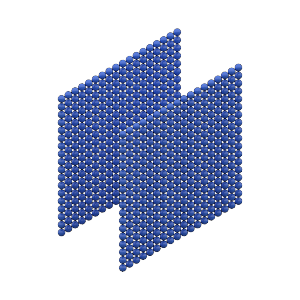

In [4]:
import ex_render
ex_render.render_sphere_frame(system.take_snapshot())

In [5]:
system.particles.types.add('A');

In [6]:
rigid = hoomd.md.constrain.rigid();
rigid.set_param('R', 
                types=['A']*8,
                positions=[(-4,0,0),(-3,0,0),(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0),(3,0,0),(4,0,0)]);

In [7]:
rigid.create_bodies()

notice(2): constrain.rigid(): Creating 648 rigid bodies (adding 5184 particles)


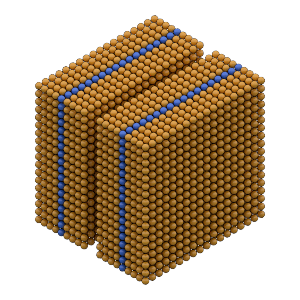

In [8]:
import ex_render
ex_render.render_sphere_frame(system.take_snapshot())

In [9]:
nl = hoomd.md.nlist.cell()

In [10]:
lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl)
lj.set_params(mode='shift')

In [11]:
lj.pair_coeff.set(['R', 'A'], ['R', 'A'], epsilon=1.0, sigma=1.0)

In [12]:
hoomd.md.integrate.mode_standard(dt=0.005);

In [13]:
rigid = hoomd.group.rigid_center();
hoomd.md.integrate.langevin(group=rigid, kT=1.0, seed=42);

notice(2): Group "rigid_center" created containing 648 particles
notice(2): integrate.langevin/bd is using specified gamma values


In [14]:
hoomd.analyze.log(filename="log-output.log",
                  quantities=['potential_energy',
                              'translational_kinetic_energy',
                              'rotational_kinetic_energy'],
                  period=100,
                  overwrite=True);

In [15]:
hoomd.dump.gsd("trajectory.gsd",
               period=2e3,
               group=hoomd.group.all(),
               overwrite=True);    

In [17]:
hoomd.run(1e4);

** starting run **
Time 00:03:38 | Step 11062 / 20000 | TPS 106.14 | ETA 00:01:24
Time 00:03:48 | Step 12133 / 20000 | TPS 107.086 | ETA 00:01:13
Time 00:03:58 | Step 13202 / 20000 | TPS 106.878 | ETA 00:01:03
Time 00:04:08 | Step 14247 / 20000 | TPS 104.27 | ETA 00:00:55
Time 00:04:18 | Step 15301 / 20000 | TPS 105.366 | ETA 00:00:44
Time 00:04:28 | Step 16379 / 20000 | TPS 107.764 | ETA 00:00:33
Time 00:04:38 | Step 17453 / 20000 | TPS 107.196 | ETA 00:00:23
Time 00:04:48 | Step 18527 / 20000 | TPS 107.339 | ETA 00:00:13
Time 00:04:58 | Step 19601 / 20000 | TPS 107.214 | ETA 00:00:03
Time 00:05:02 | Step 20000 / 20000 | TPS 105.048 | ETA 00:00:00
Average TPS: 106.506
---------
-- Neighborlist stats:
1714 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 11 / n_neigh_avg: 3.13683
shortest rebuild period: 4
-- Cell list stats:
Dimension: 14, 14, 14
n_min    : 0 / n_max: 6 / n_avg: 2.12536
** run complete **


In [18]:
import numpy
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);

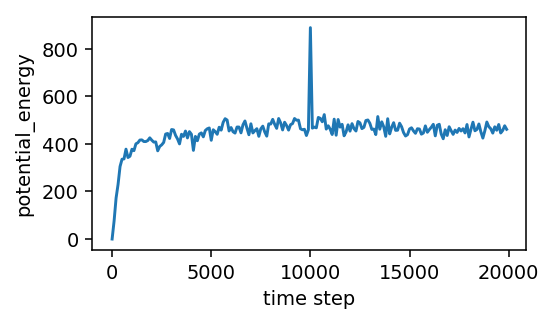

In [19]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,1]);
pyplot.xlabel('time step');
pyplot.ylabel('potential_energy');

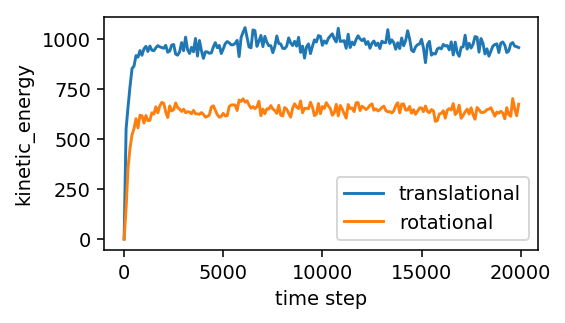

In [20]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,2]);
pyplot.plot(data[:,0], data[:,3]);
pyplot.xlabel('time step');
pyplot.ylabel('kinetic_energy');
pyplot.legend(['translational', 'rotational'], loc='lower right');

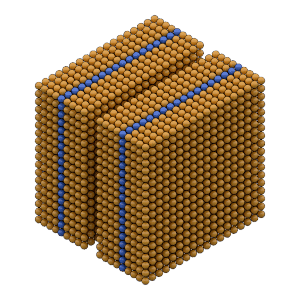

In [21]:
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory.gsd');